<a href="https://colab.research.google.com/github/jovanape/Bitcoint-Price-Prediction/blob/main/07_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predviđanje vrednosti bitkoina korišćenjem RNN**

**Korišćeni atributi:** Open, High, Low, Close

**Filtrirani podaci:** od 28.03.2021.

**Koraci:**
1. Pretprocesiranje podataka
2. Podela skupa podataka na skupove za trening, validaciju i test
3. Filtriranje atributa (kolona)
4. Odredjivanje ciljne promenljive za svaki od skupova
5. Skaliranje podataka
6. Kreiranje modela mreže
7. Kompilacija i treniranje mreže
8. Predvidjanje
9. Evaluacija

### **Učitavanje biblioteka**

In [109]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras import callbacks
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

%run 02_Preprocessing_and_data_analysis.ipynb
%run 03_Utility_functions.ipynb

In [110]:
DAYS_TO_PREDICT = 60

### **Učitavanje skupa podataka i pretprocesiranje**

In [111]:
data = preprocess_data(file_name = 'bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')

In [112]:
data = filter_data(data, date_str = '2021-03-28')

In [113]:
data

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Date
4854496,1616976000,55790.28,55822.98,55777.98,55804.36,1.731449,96636.546983,55812.518695,2021-03-29
4854497,1616976060,55822.98,55857.28,55822.98,55857.28,0.589603,32931.781301,55854.182542,2021-03-29
4854498,1616976120,55822.98,55829.04,55766.15,55779.04,2.729659,152263.034630,55780.964698,2021-03-29
4854500,1616976240,55766.15,55768.63,55766.15,55768.63,0.023738,1323.776861,55766.455065,2021-03-29
4854501,1616976300,55770.46,55778.48,55736.83,55742.20,0.389067,21692.454676,55755.006032,2021-03-29
...,...,...,...,...,...,...,...,...,...
4857372,1617148560,58714.31,58714.31,58686.00,58686.00,1.384487,81259.372187,58692.753339,2021-03-30
4857373,1617148620,58683.97,58693.43,58683.97,58685.81,7.294848,428158.146640,58693.226508,2021-03-30
4857374,1617148680,58693.43,58723.84,58693.43,58723.84,1.705682,100117.070370,58696.198496,2021-03-30
4857375,1617148740,58742.18,58770.38,58742.18,58760.59,0.720415,42332.958633,58761.866202,2021-03-30


### **Podela skupa podataka**

In [114]:
# Podela inicijalnog skupa podataka na train i test skup

train, test = data_split(data, test_size = 0.2)


# Podela train skupa podataka na train i validacioni skup

train, validation = data_split(train, test_size = 0.2)

In [115]:
# Dimenzije train, validation i test skupa

train.shape, validation.shape, test.shape

((1839, 9), (459, 9), (574, 9))

### **Vizualizacija validacionog skupa i trening skupa**

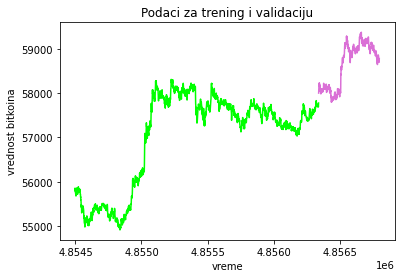

In [116]:
plot_train_and_validation_data(train = train['Close'], validation = validation['Close'])

### **Filtriranje trening, validacionog i test skupa**

In [117]:
# Izbacivanje nepotrebnih kolona (atributa) iz trening skupa

train_ = train.drop(['Date', 'Volume_(BTC)', 'Volume_(Currency)', 'Weighted_Price', 'Timestamp'], axis = 1)
# train_.head(), train_.shape

In [118]:
# Izbacivanje nepotrebnih kolona (atributa) iz validacionog skupa

validation_ = validation.drop(['Date', 'Volume_(BTC)', 'Volume_(Currency)', 'Weighted_Price', 'Timestamp'], axis = 1)
# validation_.head(), validation_.shape

In [119]:
# Izbacivanje nepotrebnih kolona (atributa) iz test skupa

test_ = test.drop(['Date', 'Volume_(BTC)', 'Volume_(Currency)', 'Weighted_Price', 'Timestamp'], axis = 1)
# test_.head(), test_.shape

In [120]:
# Dimenzije train skupa - pre i nakon izbacivanja atributa

# train.shape, train_.shape

In [121]:
# inverse = scaler.inverse_transform(normalized)

### **Odredjivanje ciljne promenljive**

In [122]:
# Odredjivanje ciljne promenljive na train skupu

X_train, y_train = determine_x_and_y(dataset = train_.to_numpy())


# Odredjivanje ciljne promenljive na validacionom skupu

X_validation, y_validation = determine_x_and_y(dataset = validation_.to_numpy())


# Odredjivanje ciljne promenljive na test skupu

X_test, y_test = determine_x_and_y(dataset = test_.to_numpy())

In [123]:
# type(X_train)

In [124]:
X_train_df = pd.DataFrame(np.concatenate(X_train))
# X_train_df

In [125]:
X_validation_df = pd.DataFrame(np.concatenate(X_validation))
# X_validation_df

In [126]:
X_test_df = pd.DataFrame(np.concatenate(X_test))
# X_test_df

### **Skaliranje**

In [127]:
X_train_df, X_validation_df, X_test_df = scale_columns(X_train_df, X_validation_df, X_test_df)

In [128]:
# Konverzija u numpy array

X_train_np = X_train_df.to_numpy()
X_validation_np = X_validation_df.to_numpy()
X_test_np = X_test_df.to_numpy()

# X_train_np.shape, X_validation_np.shape, X_test_np.shape

In [129]:
# Podela trening skupa na blokove

dim_train = int(X_train_np.shape[0] / DAYS_TO_PREDICT)

X_train = np.array(np.split(X_train_np, dim_train))

In [130]:
# X_train.shape

In [131]:
# Podela validacionog skupa na blokove

dim_validation = int(X_validation_np.shape[0] / DAYS_TO_PREDICT)

X_validation = np.array(np.split(X_validation_np, dim_validation))

In [132]:
# X_validation.shape

In [133]:
# Podela test skupa na blokove

dim_test = int(X_test_np.shape[0] / DAYS_TO_PREDICT)

X_test = np.array(np.split(X_test_np, dim_test))

In [134]:
# X_test.shape

In [135]:
# X_train[1].shape

In [136]:
# y_train[:5]

In [137]:
# Konverzija u np.array

y_train = np.array(y_train)
y_validation = np.array(y_validation)
y_test = np.array(y_test)

In [138]:
# Dimenzije X_train

# X_train.shape, y_train.shape, X_validation.shape, y_validation.shape, X_test.shape, y_test.shape

### **Kreiranje, kompilacija i treniranje mreže**

**Kreiranje mreže**

In [139]:
# Definicija funkcije koja kreira i vraca model mreze

def build_net(input_1 = X_train.shape[1], input_2 = X_train.shape[2]):

  net = Sequential()
  net.add(LSTM(units = 50, activation = 'relu', return_sequences = True, input_shape = (input_1, input_2)))
  net.add(Dropout(0.2))
  net.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
  net.add(Dropout(0.3))

  net.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
  net.add(Dropout(0.4))

  net.add(LSTM(units = 120, activation = 'relu'))
  net.add(Dropout(0.5))

  net.add(Dense(units =1))
  print(net.summary())

  return net


In [140]:
# Kreiranje modela mreze

net = build_net(input_1 = X_train.shape[1], input_2 = X_train.shape[2])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 60, 50)            11000     
_________________________________________________________________
dropout_16 (Dropout)         (None, 60, 50)            0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 60, 60)            26640     
_________________________________________________________________
dropout_17 (Dropout)         (None, 60, 60)            0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 60, 80)            45120     
_________________________________________________________________
dropout_18 (Dropout)         (None, 60, 80)            0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 120)              

**Kompilacija i treniranje mreže**

In [141]:
# Kompilacija i treniranje mreze bez validacije

history_no_validation, net_no_validation = compile_and_fit(net, optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mse', 'mae'], X_train = X_train, y_train = y_train, epochs = 20, batch_size = 50, validation = 0, patience = 3)


# Kompilacija i treniranje mreze sa validacijom

validation_data = (X_validation, y_validation)

history_validation, net_validation = compile_and_fit(net, optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mse', 'mae'], X_train = X_train, y_train = y_train, epochs = 20, batch_size = 50, validation = 1, validation_data = validation_data, patience = 3)


Epoch 1/20
36/36 [==============================] - 12s 213ms/step - loss: 3118327040.0000 - mse: 3118327040.0000 - mae: 55526.3750
Epoch 2/20
36/36 [==============================] - 8s 212ms/step - loss: 6068576256.0000 - mse: 6068576256.0000 - mae: 60110.5977
Epoch 3/20
36/36 [==============================] - 8s 209ms/step - loss: 3236295168.0000 - mse: 3236295168.0000 - mae: 56865.6406
Epoch 4/20
36/36 [==============================] - 8s 210ms/step - loss: 2845415936.0000 - mse: 2845415936.0000 - mae: 51614.1875
Epoch 5/20
36/36 [==============================] - 8s 211ms/step - loss: 3257592832.0000 - mse: 3257592832.0000 - mae: 57066.1992
Epoch 6/20
36/36 [==============================] - 8s 211ms/step - loss: 3257596160.0000 - mse: 3257596160.0000 - mae: 57066.2305
Epoch 7/20
36/36 [==============================] - 8s 210ms/step - loss: 3257591808.0000 - mse: 3257591808.0000 - mae: 57066.1836
Epoch 1/20
36/36 [==============================] - 13s 242ms/step - loss: 3304440

### **Predvidjanje**

In [142]:
# Predvidjanje za mrezu treniranu bez i sa validacijom

# Bez validacije
y_predicted_no_validation = net_no_validation.predict(X_test)
#print('Predvidjene vrednosti - bez validacije:\n', y_predicted_no_validation)

# Sa validacijom
y_predicted_validation = net_validation.predict(X_test)
#print('\nPredvidjene vrednosti - sa validacijom:\n', y_predicted_validation)

### **Vizualizacija rezultata predvidjanja**

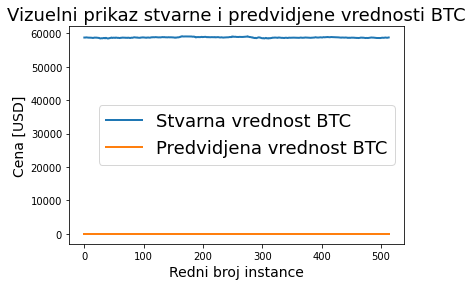

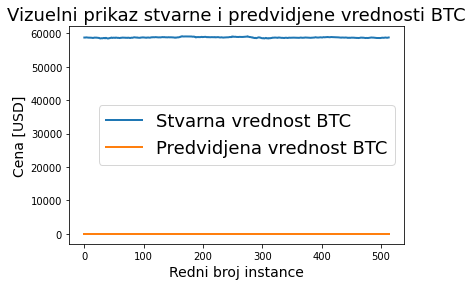

In [143]:
# Plotovanje stvarne i predvidjene vrednosti

# Bez validacije
plot_real_vs_predicted_data(test_set = y_test, predicted_set = y_predicted_no_validation)

# Sa validacijom
plot_real_vs_predicted_data(y_test, y_predicted_validation)

### **Vizualizacija rezultata predvidjanja i metrika**

### **Funkcija gubitka**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


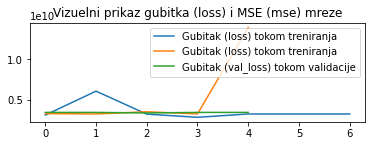

In [144]:
# Plotovanje funkcije gubitka tokom treniranja mreze

plot_loss(history_ = history_no_validation)

plot_loss(history_ = history_validation)

### **Srednja kvadratna greška**

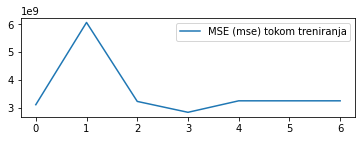

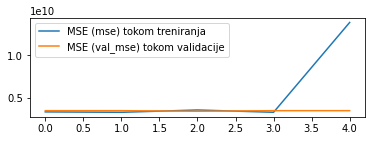

In [145]:
# Plotovanje srednje kvadratne greske tokom treniranja mreze

plot_mse(history_ = history_no_validation)

plot_mse(history_ = history_validation)

### **Srednja apsolutna greška**

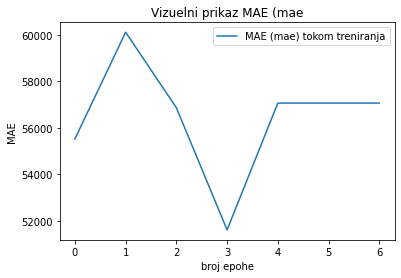

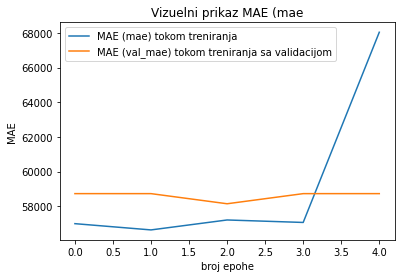

In [146]:
# Plotovanje srednje apsolutne greske tokom treniranja mreze

plot_mae(history_no_validation)


# Plotovanje srednje apsolutne greske tokom treniranja mreze sa validacijom

plot_mae(history_validation)

### **Loss, MSE, MAE**

In [147]:
# Loss, MSE, MAE nad skupom za testiranje

# (za model koji pri treniranju koristi validaciju
# i za model koji pri treniranju ne koristi validaciju)

test_metrics_no_val = net_no_validation.evaluate(X_test, y_test)
test_metrics_val = net_validation.evaluate(X_test, y_test)

print('\nMetrike prilikom testiranja - model treniran bez validacije\n')
print(net_no_validation.metrics_names[0], test_metrics_no_val[0])
print(net_no_validation.metrics_names[1], test_metrics_no_val[1])
print(net_no_validation.metrics_names[2], test_metrics_no_val[2])

print('\n\nMetrike prilikom testiranja - model treniran sa validacijom\n')
print(net_validation.metrics_names[0], test_metrics_val[0])
print(net_validation.metrics_names[1], test_metrics_val[1])
print(net_validation.metrics_names[2], test_metrics_val[2])

17/17 [==============================] - 1s 44ms/step - loss: 3452901632.0000 - mse: 3452901632.0000 - mae: 58761.2617

Metrike prilikom testiranja - model treniran bez validacije

loss 3452901632.0
mse 3452901632.0
mae 58761.26171875


Metrike prilikom testiranja - model treniran sa validacijom

loss 3452901632.0
mse 3452901632.0
mae 58761.26171875


### **Koeficijent determinacije (R2 skor)**

In [148]:
# R2 skor nad skupom za testiranje

r2 = metrics.r2_score(y_predicted_no_validation, y_test)
r2_val = metrics.r2_score(y_predicted_validation, y_test)

print('R2 skor prilikom testiranja - model treniran bez validacije', r2)
print('R2 skor prilikom testiranja - model treniran sa validacijom', r2_val)

R2 skor prilikom testiranja - model treniran bez validacije -5011024882884930.0
R2 skor prilikom testiranja - model treniran sa validacijom -5011024882884930.0


In [149]:
# Cuvanje modela

net.save('rnn_model_01.hdf5')

### Zakljucak

Koeficijent determinacije treba biti izmedju 0 i 1, a ovde se dobija negativna vrednost. Metrike loss, mse, mae imaju ogromne vrednosti. Ovaj model nije dobar.